## Overview

__Business Problem__

As a business, it is difficult to assess the appropriate value for homes in certain neighborhoods/markets. There is a need for more precision and confidence in valuation to support decision-making. Developing a data-driven / model-based approach to valuation can help to remove human bias.

As a building developer, it is difficult to weigh the importance of attributes to potential home buyers. A model-based approach can help assess what factors drive the oveall value of a home.

__Inference Problem__

X: 79 explanatory variables describing aspects of residential homes in Ames, Iowa  
y: Home price

Develop a model to predict home price based on a collection of attributes about the home and surrounding neighborhood.

__Methodology__

- Exploratory data analysis
    - Use pandas profiling minimal for overview
    - Develop calculated metrics using numerical variables
    - Apply one-hot encoding to relevant ordinal variables
- Model setup
    - Baseline set of regression models
        - Linear Regression
        - Random Forest
        - Gradient Boosting
- Model evaluation and iteration
    - Evaluate performance metrics: $R^2$, MSE, MAE, RMSE, [placeholder]
    - Assess feature importance, apply dimensionality reduction
    - Determine which models to exclude, features to exclude/include/adjust
    - Repeat model setup

#### Background Research

*How Zillow calculates home price*

> Zillow publishes Zestimate home valuations for 104 million homes across the country, and uses state of the art statistical and machine learning models that can examine hundreds of data points for each individual home.
>
> To calculate a Zestimate, Zillow uses a sophisticated neural network-based model that incorporates data from county and tax assessor records and direct feeds from hundreds of multiple listing services and brokerages. The Zestimate also incorporates:
>
> * Home characteristics including square footage, location or the number of bathrooms.
> * On-market data such as listing price, description, comparable homes in the area and days on the market
> * Off-market data — tax assessments, prior sales and other publicly available records
> * Market trends, including seasonal changes in demand
> 
> Currently, we have data for over 110 million U.S. homes and we publish Zestimates for 104 million of them.

https://www.zillow.com/research/zestimate-forecast-methodology/

From learning about how Zillow, we could try a neural network-based model, although we might not have enough data. We are provided with solely home characteristics for this project, and it seems like square footage, location, and the number of bathrooms are notable features we should include in our final model.

*Opendoor article on factors that influence home value*

Most important factors:
1. Neighborhood comps
2. Location
3. Home size and usable space
4. Age and condition
5. Upgrades and updates
6. The local market
7. Economic indicators
8. Interest rates

https://www.opendoor.com/w/blog/factors-that-influence-home-value

Based on the Opendoor article, we can potentially engineer features like "usable space" instead of having various features for area.

__Office Hours Walkthrough Notes__

- Error analysis
    - Residuals
        - How are we making errors - in the same variable, same direction?
    - We need to solve sub-problems
        - Example: Rather than the spectrum of HousePrice, maybe the proper distinction is Cheap vs. Expensive houses

## 0.0 Project Setup

### 0.1 Import libraries and data

In [1]:
# Basic
from IPython.display import display, Math
import warnings
warnings.filterwarnings('ignore')

# Statistics
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
from scipy.stats import chi2_contingency, norm, skew, kurtosis, ttest_ind

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-processing
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold
from sklearn.model_selection import cross_val_score

# Modelling
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.linear_model import ElasticNet, SGDRegressor, Ridge, Lasso, BayesianRidge, LassoLarsIC
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb

# Model evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score

In [2]:
# Colab
# train_url = "https://raw.githubusercontent.com/davidmiller2013/207-project-home-price/main/data/train.csv"
# test_url = "https://raw.githubusercontent.com/davidmiller2013/207-project-home-price/main/data/test.csv"
# house_train = pd.read_csv(train_url)
# house_test = pd.read_csv(test_url)

# Local
house_train = pd.read_csv('../data/train.csv')
house_test = pd.read_csv('../data/test.csv')

## 1.0 Exploratory Data Analysis

### 1.1 Initial EDA

In [3]:
print("\033[1m" + "Dataframe Shape" + "\033[0m")
print(f"The shape of the dataset is {house_train.shape}.")
print("\n")

print("\033[1m" + "Column Information" + "\033[0m")
print("Below are the features and the number of non-null observations of the features")
house_train.info()
print("\n")

print("\033[1m" + "Numeric Column Information" + "\033[0m")
print(house_train.describe())
print("\n")

print("\033[1m" + "Categorical Column Unique Values" + "\033[0m")
for col in house_train:
    if len(house_train[col].unique()) > 10:
        pass
    else:
        print('{}: {}'.format(col, house_train[col].unique()))

Dataframe Shape
The shape of the dataset is (1460, 81).


Column Information
Below are the features and the number of non-null observations of the features
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null

In [4]:
house_train[['YearBuilt', 'GarageYrBlt', 'YearRemodAdd']]

,YearBuilt,GarageYrBlt,YearRemodAdd
0,2003,2003.0,2003
1,1976,1976.0,1976
2,2001,2001.0,2002
3,1915,1998.0,1970
4,2000,2000.0,2000
...,...,...,...
1455,1999,1999.0,2000
1456,1978,1978.0,1988
1457,1941,1941.0,2006
1458,1950,1950.0,1996


In [5]:
# prof = ProfileReport(house_train, minimal=True)
# prof.to_file(output_file='output.html')

The `output.html` file displays information about each variable, including the number of distinct values, missing values, mean, minimum, maximum, and the distribution. From going through the list and reading the description of the features in `data_description.txt`, we chose 3 features to use for our model to predict home price. They are `LotArea`, `BedroomAbvGr`, and `FullBath`. The `LotArea` is the lot size in square feet, `BedroomAbvGr` is the number of bedrooms above grade, and `FullBath` is the number of full bathrooms above grade. We believe these features will be quite predictive of the house price.

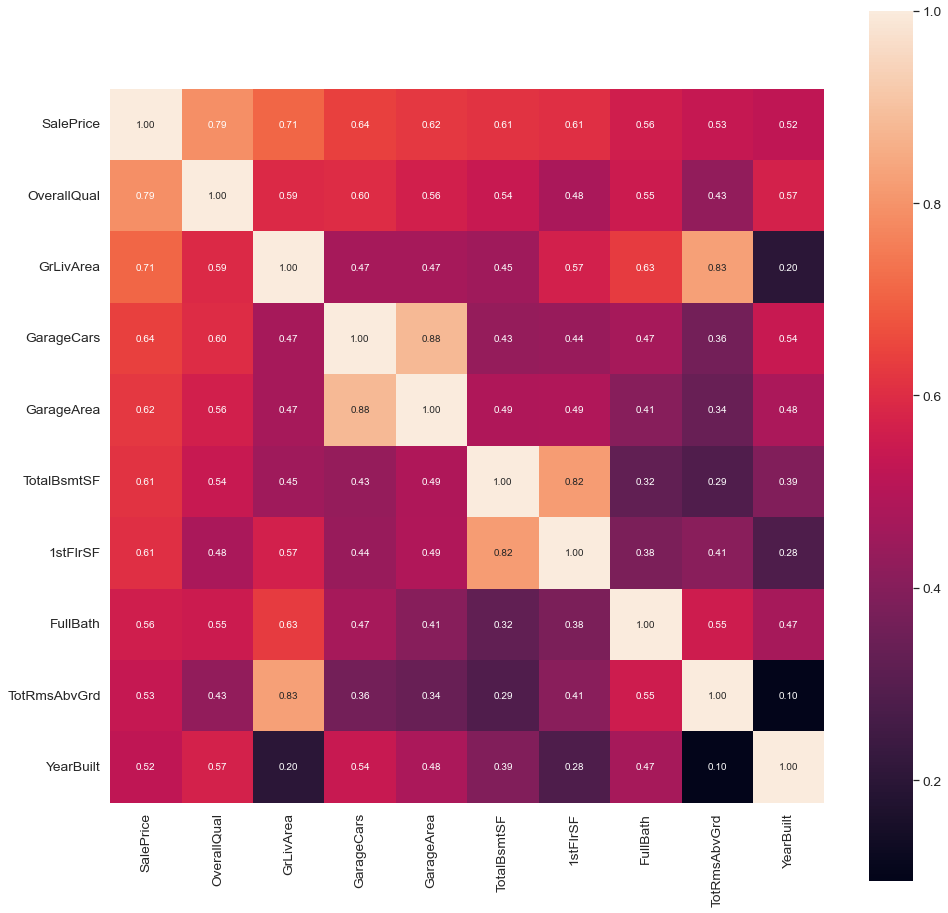

In [6]:
corrmat = house_train.corr()
k = 10

plt.figure(figsize=(16,16))
columns = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
correlation_matrix = np.corrcoef(house_train[columns].values.T)
sns.set(font_scale=1.25)
heat_map = sns.heatmap(correlation_matrix,
                       cbar=True,
                       annot=True,
                       square=True,
                       fmt='.2f',
                       annot_kws={'size': 10},
                       yticklabels=columns.values,
                       xticklabels=columns.values
                      )
plt.show()

## 2.0 Feature Engineering

### 2.1 Handle Missing Data

In [7]:
def missing_ratio(df):
    '''Calculate % of observations with a NaN value for each column of a df'''
    data_na = (df.isnull().sum() / len(df)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index)\
                     .sort_values(ascending=False)[:30]

    missing_data = pd.DataFrame({'Missing Ratio': data_na})
    return missing_data

missing_ratio(house_train)

,Missing Ratio
PoolQC,99.520548
MiscFeature,96.301370
Alley,93.767123
Fence,80.753425
FireplaceQu,47.260274
LotFrontage,17.739726
GarageType,5.547945
GarageYrBlt,5.547945
GarageFinish,5.547945
GarageQual,5.547945


In [8]:
def handle_missing_data(df,
                        drop_features=None,
                        none_features=None,
                        med_features=None,
                        mode_features=None,
                        convert_features=None
                       ):
    '''
    Perform basic feature engineering as applicable to each feature / set of features.
    Includes imputation of NaN, mean normalization, and feature dropping.

    df:                the dataframe to be transformed
    drop_features:     columns that should be dorpped from the dataframe
    none_features:     columns where NaN should be replaced with None or 0
    med_features:      numeric columns where NaN should be replaced with the median value
    mode_features:     numeric columns where NaN should be replaced with the mode value
    convert_features:  numeric columns that should be converted to ordinal features
    '''
    
    df = df.drop(drop_features, axis=1)

    for feature in none_features:
        if df[feature].dtype == 'O':
            df[feature] = df[feature].fillna("None")
        else:
            df[feature] = df[feature].fillna(0)
    
    for feature in med_features:
        df[feature] = df[feature].fillna(df[feature].median()[0])
    
    for feature in mode_features:
        df[feature] = df[feature].fillna(df[feature].mode()[0])
    
    for feature in convert_features:
        df[feature] = df[feature].astype(str)
    
    return df




In [9]:
# Features to drop from df
drop_features = ['Id', 'Utilities'] # all same value except for 2 NA

# Features to replace NaN with None or 0 - logical assumption that NaN means the house does not have X feature
none_features = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'BsmtQual',
                 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType',
                 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageYrBlt',
                 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea', 'MSSubClass'
                ]

# Features to fill NaN with the median value of the column
med_features = []


# Features to fill NaN with the mode value of the column
mode_features = ['MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd',
                 'SaleType'
                ]
    
# Numeric features that are actually ordinal and should be converted
# convert_features = ['MSSubClass', 'OverallCond', 'YrSold', 'MoSold']
convert_features = ['MSSubClass', 'OverallCond']

house_train = handle_missing_data(house_train,
                                  drop_features,
                                  none_features,
                                  med_features,
                                  mode_features,
                                  convert_features
                                 )


### 2.2 Custom transformation

In [11]:
def custom_feature_engineering(df):
    '''Apply custom operations to dataframe. Contained in a function for re-use with test data'''

    # Fill NaN values for LotFrontage with median in each neighborhood
    df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    # For Functional column, data_description.txt indicates that NaN = Typ
    df['Functional'] = df['Functional'].fillna('Typ')

    # Calculate total sqft of house as a new feature
    df['TotalSF'] = df[['TotalBsmtSF', '1stFlrSF', '2ndFlrSF']].sum(axis=1)

    return df

house_train = custom_feature_engineering(house_train)

In [12]:
# Check that there are no remaining missing values
missing_ratio(house_train)

,Missing Ratio


### 2.X Normalizing variables

In [13]:
# Explore skew and kurtosis functions in pandas and scipy
pd_skew    = house_train['LotArea'].skew()
pd_kurt    = house_train['LotArea'].kurt()
sci_skew   = skew(house_train['LotArea'], bias=False)
sci_kurt   = kurtosis(house_train['LotArea'], bias=False)
sci_skew_b = skew(house_train['LotArea'], bias=True)
sci_kurt_b = kurtosis(house_train['LotArea'], bias=True)

pd.DataFrame({'skew': [pd_skew, sci_skew, sci_skew_b],
              'kurtosis': [pd_kurt, sci_kurt, sci_kurt_b]},
             index=['pandas', 'scipy-unbiased', 'scipy-biased']
            )

,skew,kurtosis
pandas,12.207688,203.243271
scipy-unbiased,12.207688,203.243271
scipy-biased,12.195142,202.543793


In [14]:
# Calculate skew and kurtosis of all numerical features
num_features = house_train.dtypes[house_train.dtypes != "object"].index
skew_features = house_train[num_features].apply(lambda x: pd.Series({'skew': x.skew(),
                                                                     'kurtosis': x.kurtosis()
                                                                    }))
skew_df = pd.DataFrame({'skew': skew_features.loc['skew'],
                        'kurtosis': skew_features.loc['kurtosis']
                       }).sort_values(by='skew', ascending=False)
skew_df

,skew,kurtosis
MiscVal,24.476794,701.003342
PoolArea,14.828374,223.268499
LotArea,12.207688,203.243271
3SsnPorch,10.304342,123.662379
LowQualFinSF,9.011341,83.234817
KitchenAbvGr,4.488397,21.532404
BsmtFinSF2,4.255261,20.113338
ScreenPorch,4.122214,18.439068
BsmtHalfBath,4.103403,16.396642
EnclosedPorch,3.089872,10.430766


In [15]:
# Apply boxcox transformation to skewed features
from scipy.special import boxcox1p
from sklearn.preprocessing import PowerTransformer


# Explore 2 methods using highly skewed feature
temp = pd.DataFrame(house_train['LotArea'])

# Take the log10 of votes
temp['LotArea_Norm'] = boxcox1p(temp['LotArea'], 0)

# Apply power transformation
pt = PowerTransformer()
temp['LotArea_Power'] = pt.fit_transform(pd.DataFrame(temp['LotArea']))


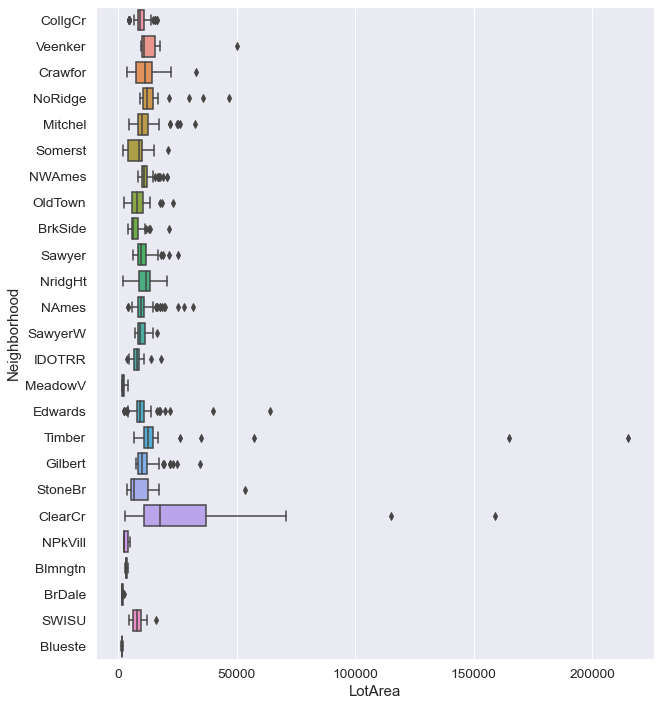

In [16]:
fig, ax = plt.subplots(figsize=(10,12))
sns.boxplot(x='LotArea', y='Neighborhood', orient='h', data=house_train)
plt.show()

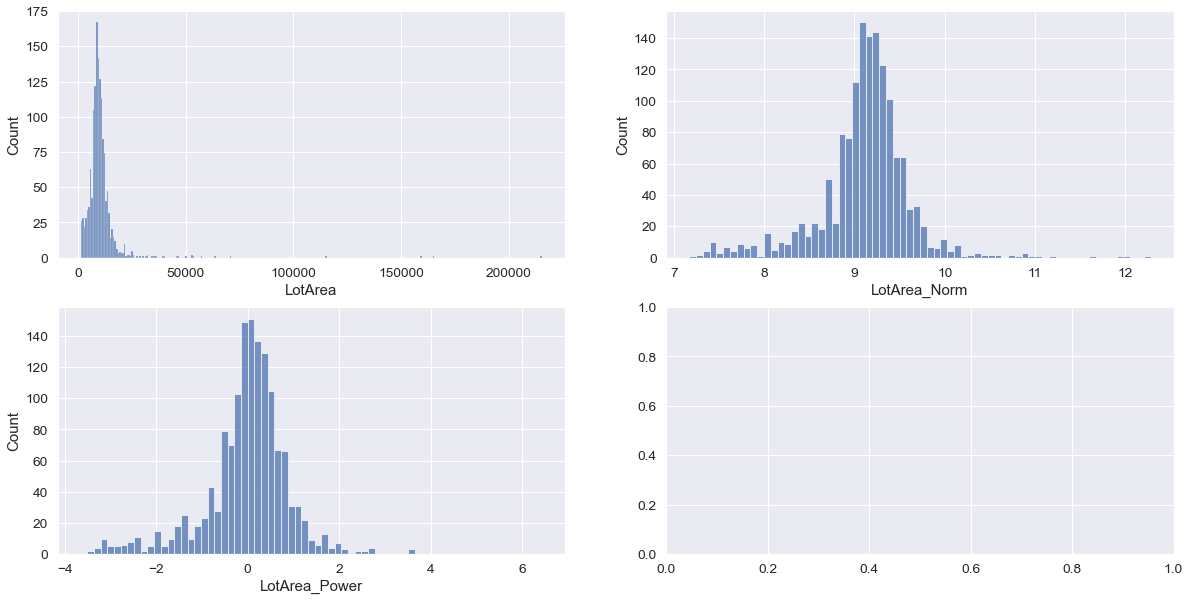

In [17]:
fig, ax = plt.subplots(2,2, figsize=(20,10))

sns.histplot(x='LotArea',
             data=temp,
             ax=ax[0][0]
            )

sns.histplot(x='LotArea_Norm',
             data=temp,
             ax=ax[0][1]
            )

sns.histplot(x='LotArea_Power',
             data=temp,
             ax=ax[1][0]
            )

plt.show()

In [18]:
# Use a power transformer to normalize all featuers with skew > 1

skew_df = skew_df[abs(skew_df['skew']) > 1]
skewed_features = list(skew_df.index)
pt = PowerTransformer()
skewed_features.remove('SalePrice')
house_train[skewed_features] = pt.fit_transform(house_train[skewed_features])

### 2.X Encoding variables

In [19]:
# Simple pandas function to replicate a OneHotEncoder
house_train = pd.get_dummies(house_train)

### 2.X Apply across test data

In [20]:
# INCOMPLETE - to be updated once feature engineering is finalized on training data

# Apply same functions to test data
house_test = handle_missing_data(house_test,
                                 drop_features,
                                 none_features,
                                 med_features,
                                 mode_features,
                                 convert_features
                                )


house_test = custom_feature_engineering(house_test)


## 3.0 Model building

In [21]:
def calculate_residuals(predictions, actuals):
    residuals = actuals - predictions
    return residuals

In [22]:
def plot_residual(y_pred, y_dev, model_name='Linear Regression v1'):
    residuals = calculate_residuals(y_pred, y_dev)
    plt.scatter(y_pred, residuals)
    plt.xlabel('Predicted Value')
    plt.ylabel('Residals')
    plt.title(f"Residual Plot of {model_name}")
    plt.axhline(y=0, color='r', linestyle='-')
    plt.show()

In [23]:
# Get the data samples with the largest residuals
def get_largest_residuals(y_pred, y_dev, n=10):
    residuals = calculate_residuals(y_pred, y_dev)
    absolute_residuals = abs(residuals)
    integer_indices = np.flip(np.argsort(absolute_residuals))[:n] # top n largest residuals
    top_residuals = absolute_residuals.iloc[integer_indices]
    return X_dev.loc[top_residuals.index]

In [24]:
def get_p_values_of_difference(X_largest_residuals, X_dev):
    for column in X_largest_residuals.columns:
        p_value = ttest_ind(X_largest_residuals[column], X_dev[column])[1]
        bonferroni_threshold = 0.05 / len(X_largest_residuals.columns)
        if p_value < bonferroni_threshold:
            significance = ", Statistically significant"
        else:
            significance = ""
        print(f"{column} p-value: {round(p_value, 3)}{significance}")

### 3.1 Model v1 - Simple linear regression

For our baseline, we are building a linear regression model with `LotArea`, `BedroomAbvGr`, and `FullBath` as features.

In [25]:
def split_model(X, y):
    X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_dev, y_train, y_dev

def evaluate_model(X_train, X_dev, y_train, y_dev, model_type, initial_model=False):
    X_train, X_dev, y_train, y_dev = split_model(X, y)
    if model_type == 'linear_regression':
        model = LinearRegression()
    if model_type == 'xgboost':
        model = xgb.XGBRegressor(colsample_bytree=0.4603,
                           gamma=0.0468, 
                           learning_rate=0.05,
                           max_depth=3, 
                           min_child_weight=1.7817,
                           n_estimators=2200,
                           reg_alpha=0.4640,
                           reg_lambda=0.8571,
                           subsample=0.5213,
                           silent=1,
                           random_state=7,
                           nthread=-1
                          )
    fitted_model = model.fit(X_train, y_train)
    r2 = fitted_model.score(X_train, y_train)

    if initial_model:
        x1, x2, x3 = fitted_model.coef_
        intercept = fitted_model.intercept_
        print("The initial model function is: y = {:.2f}x1 + {:.2f}x2 + {:.2f}x3 + {:.2f}".format(x1, x2, x3, intercept))

    model_name = ' '.join(model_type.split('_')).title()
    display(Math(r'\text{{{}}} \text{{ model performance metrics}}'.format(model_name)))

    y_pred = fitted_model.predict(X_dev)
    mae = mean_absolute_error(y_dev, y_pred)
    mse = mean_squared_error(y_dev, y_pred, squared=True)
    rmse = mean_squared_error(y_dev, y_pred, squared=False)
    

    display(Math(r'R^2 \text{{: }} {:.2f}'.format(r2)))
    display(Math(r'\text{{MAE: }} {:.2f}'.format(mae)))
    display(Math(r'\text{{MSE: }} {:.2f}'.format(mse)))
    display(Math(r'\text{{RMSE: }} {:.2f}'.format(rmse)))
    
    return y_pred, fitted_model


In [27]:
initial_features = ['LotArea', 'BedroomAbvGr', 'FullBath']

X, y = house_train[initial_features], house_train['SalePrice']
X_train, X_dev, y_train, y_dev = split_model(X, y)

y_pred, lr_model = evaluate_model(X_train, X_dev, y_train, y_dev, 'linear_regression', initial_model=True)

The initial model function is: y = 26615.41x1 + -12158.51x2 + 76132.34x3 + 95931.96


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

#### Calculate residuals

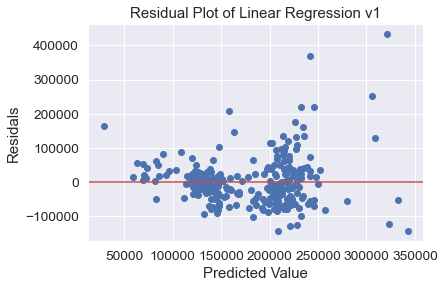

In [28]:
plot_residual(y_pred, y_dev)

The residual plot suggests a good fit. It is quite symmetrically distributed, tending to cluster towards the middle of the plot as there are more values predicted towards the mean. They are clustered around the 0 and not overly high. There isn't a strong pattern although there are residuals with a low value associated with examples with low predicted value as well.

### Individual feature error analysis

In [29]:
top_10_percent_of_X_dev = int(X_dev.shape[0] * 0.1)
X_largest_residuals = get_largest_residuals(y_pred, y_dev, n=top_10_percent_of_X_dev)
# looking at the data with the largest residuals
X_largest_residuals

,LotArea,BedroomAbvGr,FullBath
691,1.690959,4,3
898,0.683684,2,2
1046,1.110262,4,3
591,0.766583,3,2
1243,0.825717,2,2
1228,-0.069603,1,1
231,0.994448,4,2
597,-1.605292,2,0
774,0.872445,3,2
218,1.061111,3,1


In [30]:
# for each feature, look at the p-values of the difference between the top residuals and the data overall
get_p_values_of_difference(X_largest_residuals, X_dev)

LotArea p-value: 0.0, Statistically significant
BedroomAbvGr p-value: 0.171
FullBath p-value: 0.0, Statistically significant


### 3.2 Model v2 - Linear regression with complete set of features

In [31]:
X, y = house_train.drop('SalePrice', axis=1), house_train['SalePrice']
X_train, X_dev, y_train, y_dev = split_model(X, y)
y_pred, lr_model = evaluate_model(X_train, X_dev, y_train, y_dev, 'linear_regression')

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

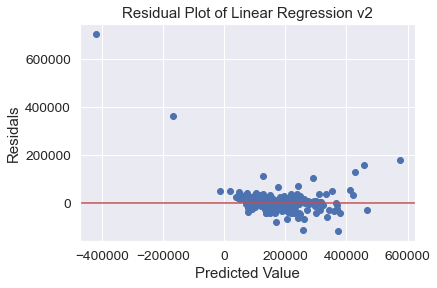

In [32]:
plot_residual(y_pred, y_dev, model_name = 'Linear Regression v2')

The residual plot suggests a good fit generally, but it has some outliers. Other than the outliers, the residual plot is also quite symmetrically distributed, tending to cluster towards the middle of the plot as there are more values predicted towards the mean. They are clustered around the 0 and not overly high. There isn't a strong pattern.

In [33]:
top_10_percent_of_X_dev = int(X_dev.shape[0] * 0.1)
X_largest_residuals = get_largest_residuals(y_pred, y_dev, n=top_10_percent_of_X_dev)
# looking at the data with the largest residuals
X_largest_residuals

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
332,0.728301,0.307990,8,2003,2004,1.304910,1.107799,2.783551,1603,4.137573,...,0,0,0,1,0,0,0,0,1,0
948,-0.159666,0.841880,7,2002,2002,1.170255,-1.353159,-0.359384,936,-0.216657,...,0,0,0,1,0,0,0,0,1,0
691,1.472175,1.690959,10,1994,1995,1.505211,1.294843,-0.359384,989,2.812686,...,0,0,0,1,0,0,0,0,1,0
898,1.322105,0.683684,9,2009,2010,1.449354,1.614017,-0.359384,142,2.605790,...,0,1,0,0,0,0,0,0,0,1
1046,0.728301,1.110262,9,2005,2006,1.241860,0.193574,-0.359384,1752,1.976080,...,0,1,0,0,0,0,0,0,0,1
581,1.245853,0.650871,8,2008,2009,1.310578,-1.353159,-0.359384,2042,2.070889,...,0,1,0,0,0,0,0,0,0,1
588,-0.159666,1.995644,5,1968,2003,-0.818452,1.225185,-0.359384,113,0.876671,...,0,0,0,1,0,0,0,0,0,1
271,0.211095,2.887180,7,1954,2005,-0.818452,0.164155,2.783735,96,0.768461,...,0,0,0,1,0,0,0,0,1,0
774,1.691539,0.872445,8,2006,2006,1.344293,-1.353159,-0.359384,1935,1.867239,...,0,1,0,0,0,0,0,0,0,1
479,-0.927855,-0.822632,4,1937,2000,1.367881,0.024860,-0.359384,739,-0.284079,...,0,0,0,1,0,0,1,0,0,0


In [34]:
# for each feature, look at the p-values of the difference between the top residuals and the data overall
get_p_values_of_difference(X_largest_residuals, X_dev)

LotFrontage p-value: 0.017
LotArea p-value: 0.0, Statistically significant
OverallQual p-value: 0.021
YearBuilt p-value: 0.284
YearRemodAdd p-value: 0.051
MasVnrArea p-value: 0.119
BsmtFinSF1 p-value: 0.101
BsmtFinSF2 p-value: 0.756
BsmtUnfSF p-value: 0.052
TotalBsmtSF p-value: 0.0, Statistically significant
1stFlrSF p-value: 0.0, Statistically significant
2ndFlrSF p-value: 0.801
LowQualFinSF p-value: 0.512
GrLivArea p-value: 0.003
BsmtFullBath p-value: 0.368
BsmtHalfBath p-value: 0.014
FullBath p-value: 0.036
HalfBath p-value: 0.546
BedroomAbvGr p-value: 0.785
KitchenAbvGr p-value: 0.13
TotRmsAbvGrd p-value: 0.004
Fireplaces p-value: 0.0
GarageYrBlt p-value: 0.899
GarageCars p-value: 0.01
GarageArea p-value: 0.005
WoodDeckSF p-value: 0.977
OpenPorchSF p-value: 0.037
EnclosedPorch p-value: 0.913
3SsnPorch p-value: 0.036
ScreenPorch p-value: 0.517
PoolArea p-value: 0.753
MiscVal p-value: 0.826
MoSold p-value: 0.468
YrSold p-value: 0.481
TotalSF p-value: 0.0, Statistically significant
MS

In [35]:
# Average year built for the houses that have the largest residuals in the dev set
round(X_largest_residuals.YearBuilt.mean())

1978

In [36]:
# Average year built for all the houses in the dev set
round(X_dev.YearBuilt.mean())

1972

The null hypothesis here is that, for a feature, the difference in the examples that have the largest residuals and all the examples are the same.

The p-value is the probability of observing the data given that the null hypothesis is true. 

From this list, it looks like the year built has one of the lowest p-values. The average year built for the houses that have the largest residuals in the dev set is 1956 while the average year built for the houses in the dev set is 1972. This suggests that we may need a separate fit for older houses.

### 3.3 Model v3 - Linear regression with complete set of features and inflation adjustments

Estimate the year sold by looking the max of year built and year model add

In [127]:
model = LinearRegression()

# Get the data
X, y = house_train.drop('SalePrice', axis=1), house_train['SalePrice']
X_train, X_dev, y_train, y_dev = split_model(X, y)

# Year Sold
X_train_year_sold = X_train['YrSold']
X_train.drop(columns=['YrSold'], inplace=True)
X_dev_year_sold = X_dev['YrSold']
X_dev.drop(columns=['YrSold'], inplace=True)

# Fit a model
fitted_model = model.fit(X_train, y_train)
# r2 = fitted_model.score(X_train, y_train)
y_pred = fitted_model.predict(X_dev)
mae = mean_absolute_error(y_dev, y_pred)
mse = mean_squared_error(y_dev, y_pred, squared=True)
rmse = mean_squared_error(y_dev, y_pred, squared=False)

display(Math(r'R^2 \text{{: }} {:.2f}'.format(r2)))
display(Math(r'\text{{MAE: }} {:.2f}'.format(mae)))
display(Math(r'\text{{MSE: }} {:.2f}'.format(mse)))
display(Math(r'\text{{RMSE: }} {:.2f}'.format(rmse)))

# Used to calculate price adjustment accounting for inflation
def adjust_price(original_price, year):
    adjustment_years = year - 2008
    average_inflation_rate = 0.0123
    total_inflation_rate = (1 + average_inflation_rate) ** adjustment_years
    adjusted_price = original_price * total_inflation_rate
    return adjusted_price

df_temp = pd.DataFrame(data=X_dev_year_sold)
df_temp['y_pred'] = fitted_model.predict(X_dev)
df_temp['Adjusted'] = df_temp.apply(lambda x: adjust_price(x.y_pred, x.YrSold), axis=1)


mae = mean_absolute_error(y_dev, df_temp['Adjusted'])
mse = mean_squared_error(y_dev, df_temp['Adjusted'], squared=True)
rmse = mean_squared_error(y_dev, df_temp['Adjusted'], squared=False)

display(Math(r'\text{{MAE: }} {:.2f}'.format(mae)))
display(Math(r'\text{{MSE: }} {:.2f}'.format(mse)))
display(Math(r'\text{{RMSE: }} {:.2f}'.format(rmse)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

The inflation adjusted model did not do as well in terms of RMSE in linear regression with all features as the non-inflation adjusted model.

### 3.X Cross validation

In [58]:
# Validation function
n_folds = 5

def model_cross_val(model, X, y):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X.values)
    rmse = np.sqrt(-cross_val_score(model, X.values, y, scoring="neg_mean_squared_error", cv = kf)).mean()
    return rmse

### 3.X Model selection

In [59]:
# Lasso ridge
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

# Elastic net
enet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

# Kernel ridge
krr = KernelRidge(alpha=0.6,
                  kernel='polynomial',
                  degree=2,
                  coef0=2.5
                 )

# Gradient boosting
gboost = GradientBoostingRegressor(n_estimators=3000,
                                   learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15,
                                   min_samples_split=10, 
                                   loss='huber',
                                   random_state=5
                                  )

# XGBoost
xgboost = xgb.XGBRegressor(colsample_bytree=0.4603,
                           gamma=0.0468, 
                           learning_rate=0.05,
                           max_depth=3, 
                           min_child_weight=1.7817,
                           n_estimators=2200,
                           reg_alpha=0.4640,
                           reg_lambda=0.8571,
                           subsample=0.5213,
                           silent=1,
                           random_state=7,
                           nthread=-1
                          )

# LightGB
lgboost = lgb.LGBMRegressor(objective='regression',
                            num_leaves=5,
                            learning_rate=0.05, 
                            n_estimators=720,
                            max_bin=55,
                            bagging_fraction=0.8,
                            bagging_freq=5,
                            feature_fraction=0.2319,
                            feature_fraction_seed=9,
                            bagging_seed=9,
                            min_data_in_leaf=6,
                            min_sum_hessian_in_leaf=11
                           )

# Random forest
rforest = RandomForestRegressor(max_depth=2, random_state=0)

names = ['Lasso', 'Elastic Net', 'Kernel Ridge', 'Gradient Boost', 'XGBoost', 'LightGB', 'Random Forest']
models = [lasso, enet, krr, gboost, xgboost, lgboost, rforest]

models = dict(zip(names, models))

In [60]:
def model_cross_val(model, X, y):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X.values)
    rmse = np.sqrt(-cross_val_score(model, X.values, y, scoring="neg_mean_squared_error", cv = kf)).mean()
    return rmse

In [61]:
%%time
# Note this cell takes a very long time to execute unless using a GPU 
print("RMSE for each model in our set")
print("------------------------------")

for name, model in models.items():
    rmse = model_cross_val(model, X_train, y_train)
    print("{}: {:4f}".format(name, rmse))

print("\n")

RMSE for each model in our set
------------------------------
Lasso: 39546.423563
Elastic Net: 38441.013038
Kernel Ridge: 53834.399368
Gradient Boost: 26402.450275
[19:26:04] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:26:11] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:26:17] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, wi

Residual plot for each model in our set
------------------------------


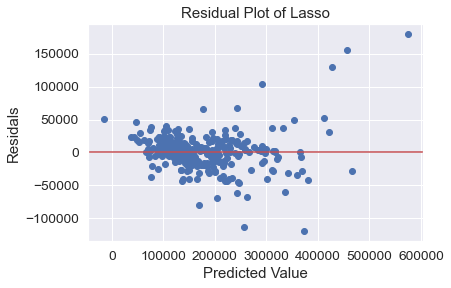

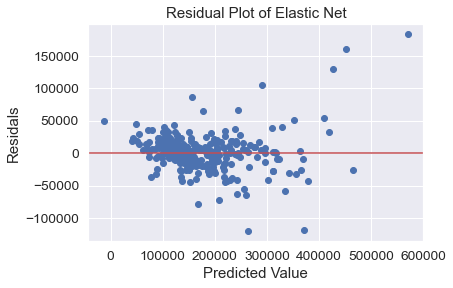

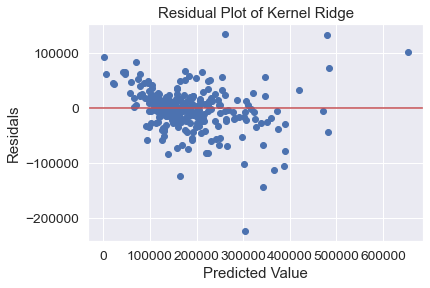

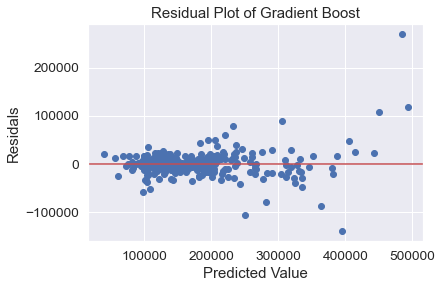

[19:26:51] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




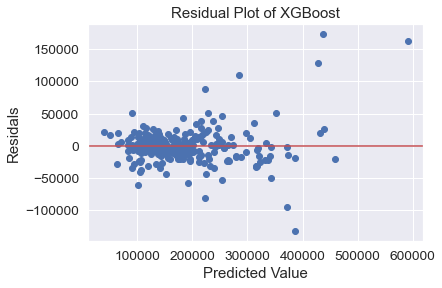

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


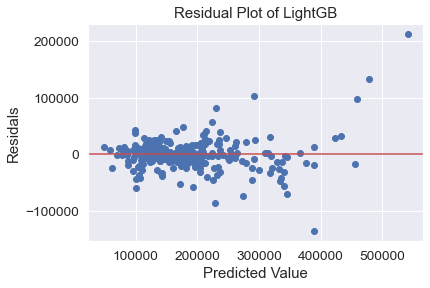

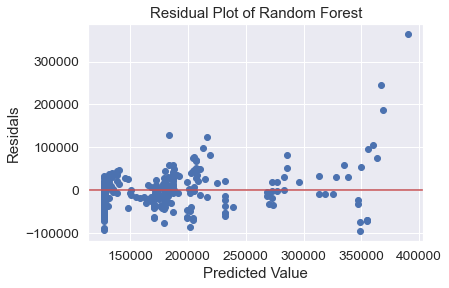

CPU times: user 59.9 s, sys: 12.1 s, total: 1min 11s
Wall time: 17.7 s


In [62]:
%%time
print("Residual plot for each model in our set")
print("------------------------------")

for name, model in models.items():
    plt.title(f'{name}')
    fitted_model = model.fit(X_train, y_train)
    y_pred = fitted_model.predict(X_dev)
    plot_residual(y_pred, y_dev, model_name=name)

Out of these models, XGBoost has the best residual plot.

### Looking at XGBoost in more detail
Since LightGBM produced the lowest error, we now do the error analysis on this model to improve it.

In [63]:
X, y = house_train.drop('SalePrice', axis=1), house_train['SalePrice']
X_train, X_dev, y_train, y_dev = split_model(X, y)
y_pred, xgb_model = evaluate_model(X_train, X_dev, y_train, y_dev, 'xgboost')

[19:27:02] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [64]:
top_10_percent_of_X_dev = int(X_dev.shape[0] * 0.1)
X_largest_residuals = get_largest_residuals(y_pred, y_dev, n=top_10_percent_of_X_dev)
get_p_values_of_difference(X_largest_residuals, X_dev)

LotFrontage p-value: 0.062
LotArea p-value: 0.002
OverallQual p-value: 0.104
YearBuilt p-value: 0.661
YearRemodAdd p-value: 0.559
MasVnrArea p-value: 0.11
BsmtFinSF1 p-value: 0.533
BsmtFinSF2 p-value: 0.389
BsmtUnfSF p-value: 0.045
TotalBsmtSF p-value: 0.001
1stFlrSF p-value: 0.0
2ndFlrSF p-value: 0.206
LowQualFinSF p-value: 0.479
GrLivArea p-value: 0.001
BsmtFullBath p-value: 0.368
BsmtHalfBath p-value: 0.291
FullBath p-value: 0.015
HalfBath p-value: 0.205
BedroomAbvGr p-value: 0.356
KitchenAbvGr p-value: 0.13
TotRmsAbvGrd p-value: 0.002
Fireplaces p-value: 0.009
GarageYrBlt p-value: 0.556
GarageCars p-value: 0.018
GarageArea p-value: 0.011
WoodDeckSF p-value: 0.808
OpenPorchSF p-value: 0.298
EnclosedPorch p-value: 0.56
3SsnPorch p-value: 0.39
ScreenPorch p-value: 0.517
PoolArea p-value: 0.753
MiscVal p-value: 0.22
MoSold p-value: 0.506
YrSold p-value: 0.316
TotalSF p-value: 0.0
MSSubClass_120 p-value: 0.643
MSSubClass_160 p-value: 0.744
MSSubClass_180 p-value: 0.585
MSSubClass_190 p-

Similar to linear regression, the p-value for built year is also low. The overall quality is also low. Hence we can potentially build separate models based on those.

### X.X Feature selection - investigate features to trim those with 0 importance

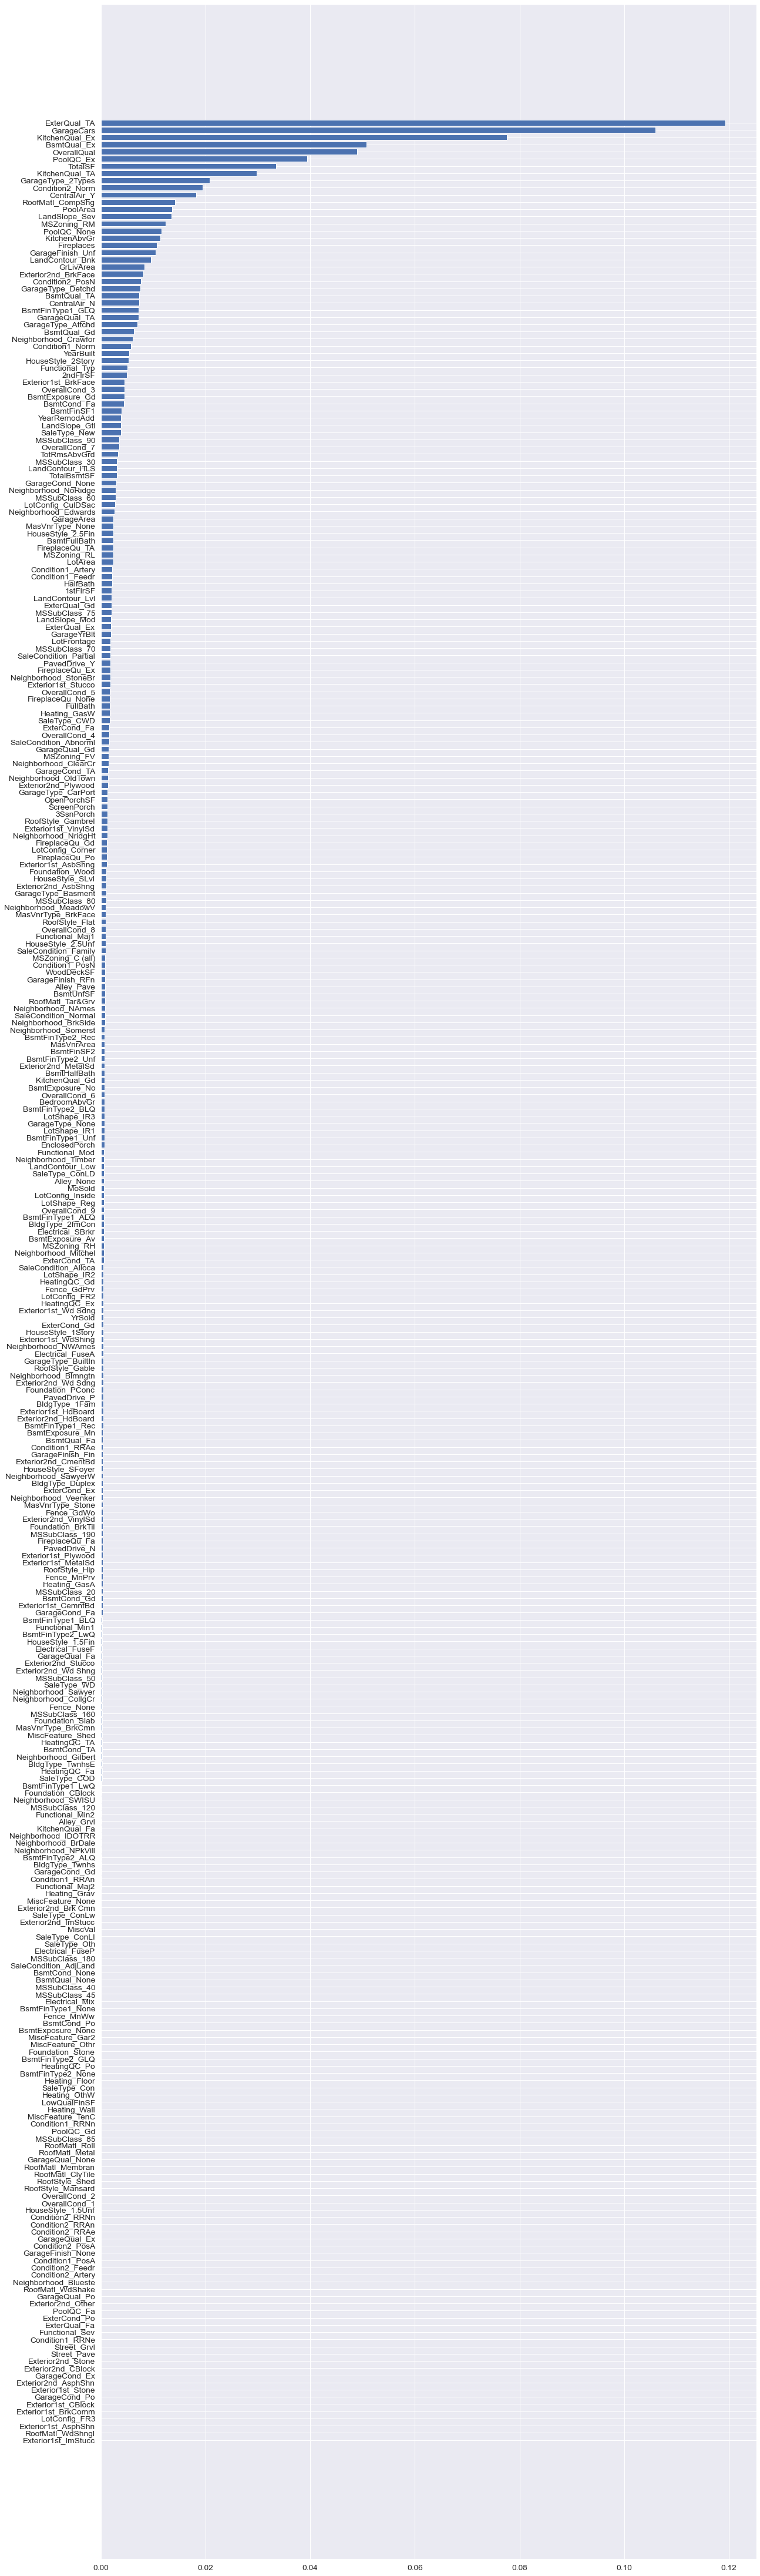

In [65]:
fig, ax = plt.subplots(figsize=(20,80))

features = X_train.columns
importances = xgb_model.feature_importances_
feature_importances = pd.DataFrame(data={'feature':features,
                                         'importance': importances
                                        }
                                  )\
                        .sort_values(by=['importance'])

ax.barh(feature_importances['feature'], feature_importances['importance'])
plt.show()

In [66]:
print(feature_importances[feature_importances['importance'] > 0]\
      .sort_values(by='importance', ascending=False)\
      .to_string()
     )

                   feature  importance
192           ExterQual_TA    0.119257
23              GarageCars    0.105900
251         KitchenQual_Ex    0.077542
204            BsmtQual_Ex    0.050804
2              OverallQual    0.048920
294              PoolQC_Ex    0.039404
34                 TotalSF    0.033486
254         KitchenQual_TA    0.029776
268      GarageType_2Types    0.020744
112        Condition2_Norm    0.019436
245           CentralAir_Y    0.018207
147       RoofMatl_CompShg    0.014118
30                PoolArea    0.013560
75           LandSlope_Sev    0.013482
54             MSZoning_RM    0.012343
297            PoolQC_None    0.011599
19            KitchenAbvGr    0.011402
21              Fireplaces    0.010699
278       GarageFinish_Unf    0.010519
64         LandContour_Bnk    0.009599
13               GrLivArea    0.008328
172    Exterior2nd_BrkFace    0.008060
114        Condition2_PosN    0.007717
273      GarageType_Detchd    0.007547
208            BsmtQual_T

In [67]:
features_to_keep = list(feature_importances[feature_importances['importance'] > 0]['feature'])
new_house_train = house_train[features_to_keep]

In [68]:
X, y = new_house_train, house_train['SalePrice']
X_train, X_dev, y_train, y_dev = split_model(X, y)
y_pred, new_xgb_model = evaluate_model(X_train, X_dev, y_train, y_dev, 'xgboost')

[19:27:13] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Gradient Boosting with Inflation

In [132]:
model = xgboost

# Get the data
X, y = new_house_train, house_train['SalePrice']
X_train, X_dev, y_train, y_dev = split_model(X, y)


# Year Sold
X_train_year_sold = X_train['YrSold']
X_train.drop(columns=['YrSold'], inplace=True)
X_dev_year_sold = X_dev['YrSold']
X_dev.drop(columns=['YrSold'], inplace=True)

# Fit a model
fitted_model = model.fit(X_train, y_train)
# r2 = fitted_model.score(X_train, y_train)
y_pred = fitted_model.predict(X_dev)

# Used to calculate price adjustment accounting for inflation
def adjust_price(original_price, year):
    adjustment_years = year - 2008
    average_inflation_rate = 0.0123
    total_inflation_rate = (1 + average_inflation_rate) ** adjustment_years
    adjusted_price = original_price * total_inflation_rate
    return adjusted_price

df_temp = pd.DataFrame(data=X_dev_year_sold)
df_temp['y_pred'] = fitted_model.predict(X_dev)
df_temp['Adjusted'] = df_temp.apply(lambda x: adjust_price(x.y_pred, x.YrSold), axis=1)


mae = mean_absolute_error(y_dev, df_temp['Adjusted'])
mse = mean_squared_error(y_dev, df_temp['Adjusted'], squared=True)
rmse = mean_squared_error(y_dev, df_temp['Adjusted'], squared=False)

display(Math(r'\text{{MAE: }} {:.2f}'.format(mae)))
display(Math(r'\text{{MSE: }} {:.2f}'.format(mse)))
display(Math(r'\text{{RMSE: }} {:.2f}'.format(rmse)))

[20:11:49] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>